## <center>Transfer learning in image classification</center>

In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand


Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while
solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to
recognize cars could apply when trying to recognize trucks.


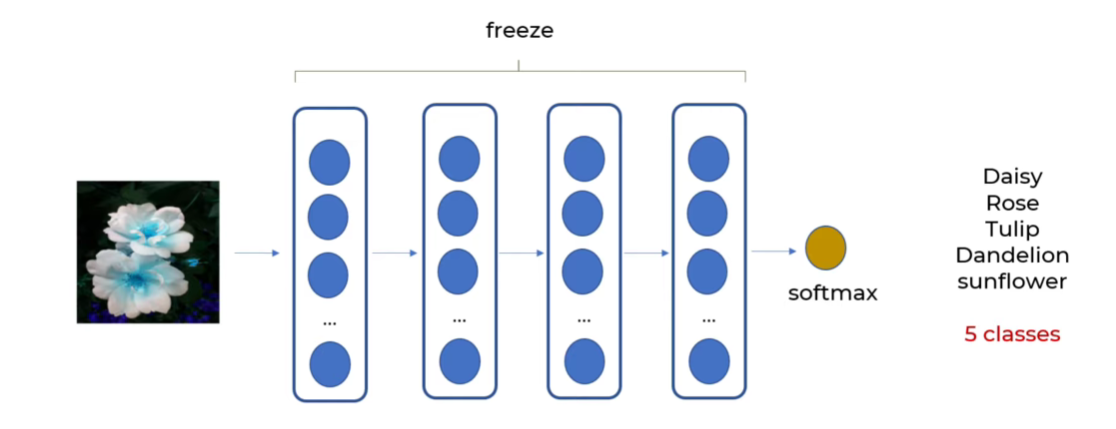


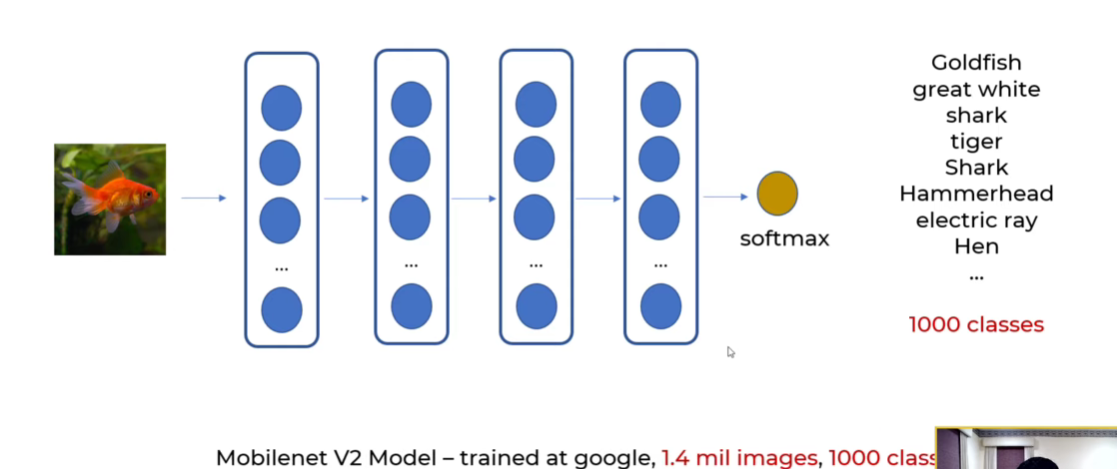


In [1]:
%pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\91630\.conda\envs\tf1\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPUs found and configured.")
else:
    print("No GPUs found.")

GPUs found and configured.


In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])
# IMAGE_SPAPE+(3,) =>224 x 224 x 3
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [5]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

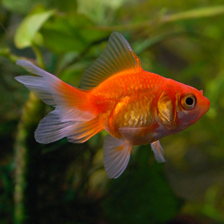

In [6]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [7]:
# scaling or normalizing
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [8]:
gold_fish[np.newaxis, ...].shape  # adding a new dimension

(1, 224, 224, 3)

In [9]:
result = classifier.predict(gold_fish[np.newaxis, ...])

1/1 [==============================] - 8s 8s/step


In [10]:
result.shape

(1, 1001)

In [11]:
result

array([[ 0.22101465,  2.0474946 ,  9.622568  , ..., -1.4621564 ,
        -0.28146613, -0.25984776]], dtype=float32)

In [12]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [13]:
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()

image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [14]:
image_labels[predicted_label_index]

'goldfish'

**Load flowers dataset**


In [15]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [16]:
data_dir

'.\\datasets\\flower_photos'

In [17]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [18]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [20]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

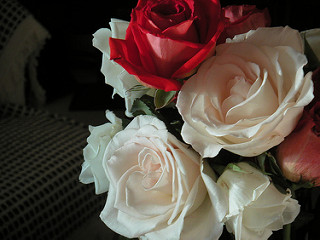

In [21]:
Image.open(str(roses[1]))

In [22]:
tulips = list(data_dir.glob('tulips/*'))
tulips[:5]

[WindowsPath('datasets/flower_photos/tulips/100930342_92e8746431_n.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10094729603_eeca3f2cb6.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10094731133_94a942463c.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10128546863_8de70c610d.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10163955604_ae0b830975_n.jpg')]

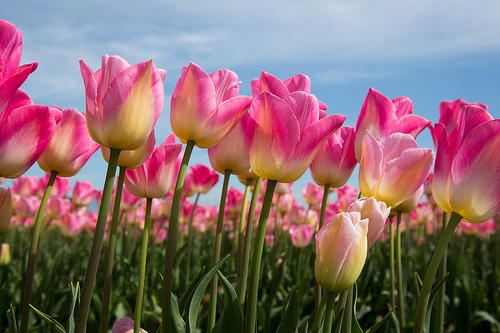

In [23]:
Image.open(str(tulips[3]))

**Read flowers images from disk into numpy array using opencv**


In [24]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [25]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [26]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [27]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [28]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [29]:
img.shape

(240, 179, 3)

In [30]:
cv2.resize(img, (224, 224)).shape

(224, 224, 3)

In [31]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [32]:
X = np.array(X)
y = np.array(y)

**Train test split**


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**Preprocessing: scale images**


In [34]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**


In [35]:
X[0].shape

(224, 224, 3)

In [36]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [37]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

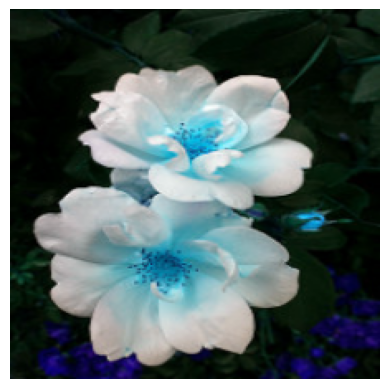

In [38]:
plt.axis('off')
plt.imshow(X[0])

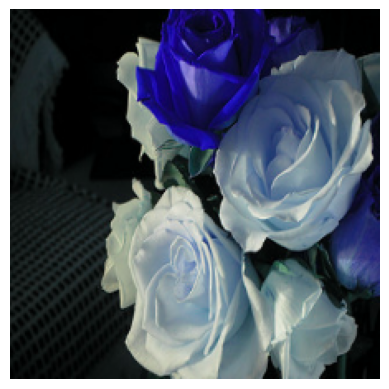

In [39]:
plt.axis('off')
plt.imshow(X[1])

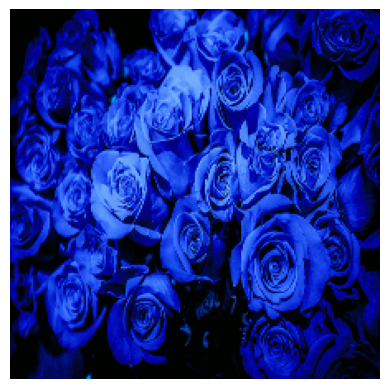

In [40]:
plt.axis('off')
plt.imshow(X[2])

In [41]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 2s 2s/step


array([795, 880, 795], dtype=int64)

In [42]:
image_labels[795]

'shower curtain'

**Now take pre-trained model and retrain it using flowers images**


In [43]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [44]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 10s 64ms/step - loss: 0.8150 - acc: 0.6959
Epoch 2/5
86/86 [==============================] - 5s 62ms/step - loss: 0.4003 - acc: 0.8681
Epoch 3/5
86/86 [==============================] - 5s 63ms/step - loss: 0.3155 - acc: 0.8986
Epoch 4/5
86/86 [==============================] - 5s 63ms/step - loss: 0.2605 - acc: 0.9175
Epoch 5/5
86/86 [==============================] - 5s 62ms/step - loss: 0.2284 - acc: 0.9320


In [46]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [48]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear any previous session
K.clear_session()

# Ensure GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Ensure data is on the correct device
with tf.device('/CPU:0'):
    X_test_scaled = tf.convert_to_tensor(X_test_scaled)
    y_test = tf.convert_to_tensor(y_test)

# Evaluate the model
with tf.device('/GPU:0'):
    model.evaluate(X_test_scaled, y_test)

Num GPUs Available:  1
29/29 [==============================] - 4s 90ms/step - loss: 0.3741 - acc: 0.8715
